# DSSC detector geometry

As of version 0.5, `karabo_data` has geometry code for the DSSC detector.
This doesn't currently account for the hexagonal pixels of DSSC, but it's
good enough for a preview of detector images.

In [1]:
%matplotlib inline
from karabo_data.geometry2 import DSSC_1MGeometry

In [2]:
# Made up numbers!
quad_pos = [
    (-130, 5),
    (-130, -125),
    (5, -125),
    (5, 5),
]
path = 'dssc_geo_june19.h5'

g = DSSC_1MGeometry.from_h5_file_and_quad_positions(path, quad_pos)

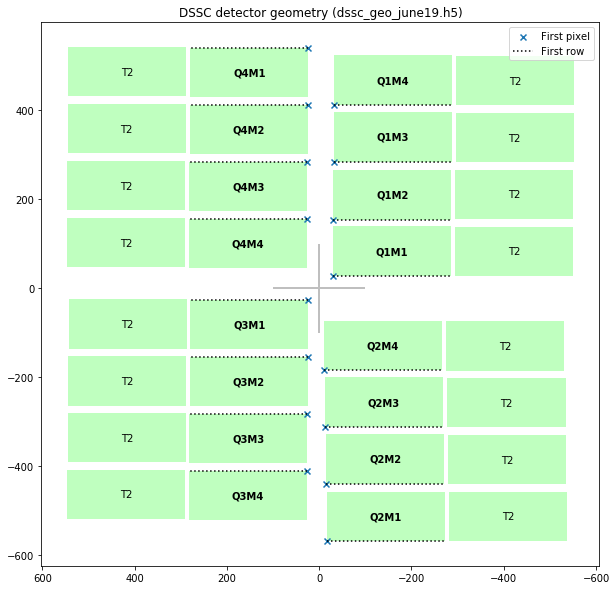

In [3]:
g.inspect()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
g.expected_data_shape

(16, 128, 512)

We'll use some empty data to demonstate assembling an image.

In [6]:
a = np.zeros(g.expected_data_shape)

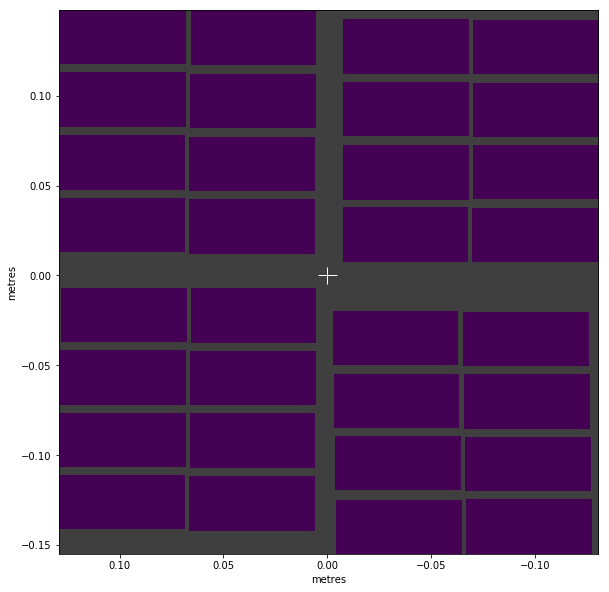

In [7]:
g.plot_data_fast(a, axis_units='m');